In [3]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns

In [4]:
master = pd.read_csv("../data/master.csv")
master = master.drop(['ENDOWMENT03', 'INSTNAME', 'INSTNAME.1', 'CPI_INDEX', 'HEPI_INDEX'], axis=1)

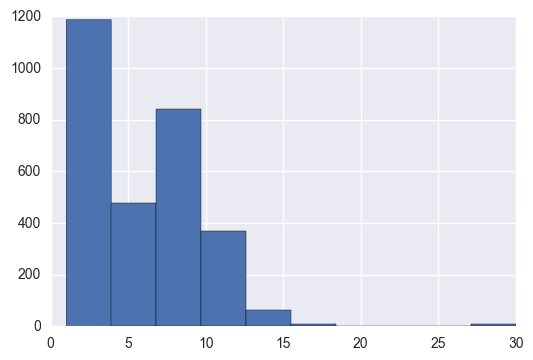

In [5]:
nans = pd.isnull(master)
nans_copy = pd.isnull(master)

from collections import Counter

university_nans = Counter()
column_count_nans = Counter()

for index, row in zip(nans_copy.index, nans_copy.values):
    row_data = dict(zip(nans_copy.columns.values, row))
    for column, value in row_data.items():
        if value:
            university_nans[index] += 1
            column_count_nans[column] += 1
            
# A good number of our institutions have between 0 and 10 NaN values.
university_nan_dist = pd.DataFrame.from_dict(university_nans, orient='index').reset_index()
university_nan_dist = university_nan_dist.rename(columns={'index':'event', 0:'count'})
plt.hist(university_nan_dist['count'])

# Feature to NaN DataFrame
column_nan_dist = pd.DataFrame.from_dict(column_count_nans, orient='index').reset_index()
column_nan_dist = column_nan_dist.rename(columns={'index':'event', 0:'count'})
column_nan_dist['count'] = column_nan_dist['count'].astype(int)

In [6]:
import statsmodels.stats.api as sms

conf_interval = {feature: 0 for feature in column_nan_dist['event']}

for feature in conf_interval.keys():
    valid, invalid = master[master[feature].notnull()], master[master[feature].isnull()]
    valid, invalid = valid['DRate 1'], invalid['DRate 1']
    
    cm = sms.CompareMeans(sms.DescrStatsW(invalid), sms.DescrStatsW(valid))
    conf_interval[feature] = cm.tconfint_diff(usevar='unequal')
    
pprint(conf_interval)

{'ACADSUPP01': (2.5303419360838744, 3.4402916645325989),
 'CERTIFICATES_AWARDS_100FTE': (-5.0961789305477616, -4.1897870572708555),
 'FED_GRANT_PCT': (-8.3490892533184997, -7.3818848886231789),
 'FT_FACULTY_PER_100FTE': (-2.767175919857924, -0.03375633457421312),
 'FT_FIRST_TIME_FIRST_YR_DEG_SEEK': (-8.3289256659697202, -7.377108316145037),
 'GRANT01': (-8.2559830511330823, -6.9233030715492667),
 'GRANT02': (-0.4041207642315563, 0.64608561166785639),
 'GRANT07': (-6.7068444913146852, -2.8702504025999804),
 'INSTITUTIONAL_GRANT_AID_SHARE': (2.6150183073209754, 3.5739226117335376),
 'INST_GRANT_AVG_AMOUNT': (-0.89134100641792346, 0.084720696926640526),
 'INST_GRANT_PCT': (-8.3490892533184997, -7.3818848886231789),
 'LOAN_AVG_AMOUNT': (-7.585772115806197, -6.314193280813635),
 'LOAN_PCT': (-8.3490892533184997, -7.3818848886231789),
 'NETTUITION01': (-7.7243345543648081, -0.15345867697501436),
 'NETTUITION_SHARE': (-7.0170814760864255, -0.0058133661453014795),
 'NET_STUDENT_TUITION': (-7.7

In [7]:
imputable = """
GRANT02
INST_GRANT_AVG_AMOUNT
STUDSERV01
TOTAL03_REVENUE
TOTALCOMPLETIONS_100FTE
TOTAL_ENROLLMENT_ASIAN_TOT
TOTAL_ENROLLMENT_BLACK_TOT
TOTAL_ENROLLMENT_HISP_TOT
TOTAL_ENROLLMENT_WHITE_TOT
""".split()


imputable = [feature for feature, interval in conf_interval.items() 
             if interval[0] <= 0 <= interval[1] or interval[1] >= 0 >= interval[0]]

non_imputable = [feature for feature in conf_interval.keys() if feature not in imputable]

In [8]:
# fig = plt.figure()
# ax = fig.add_subplot(111)

# for feature, confidence in conf_interval.items():
#     plt.scatter(conf_interval[feature][0], conf_interval[feature][1])

# ax.axis([-30, 30, -30, 30])
# plt.show()

In [9]:
# TODO revisit if we decide to go with clustering
master = master.drop(non_imputable, axis=1)

for feature in imputable:
    master[feature + '_missing'] = master[feature].isnull().astype(int)
    valid_values = master[feature].dropna()
    mean = np.mean(valid_values)
    master[feature].replace({np.nan: mean}, inplace=True)

In [10]:
categoricals = {}

for column in master.columns.values:
    values = set(master[column].values)
    if len(values) < 30 and len(values) != 2:
        categoricals[column] = values

categoricals

{'CENSUS_REGION': {1, 2, 3, 4, 5},
 'CONTROL_x': {1, 2, 3},
 'CONTROL_y': {1, 2, 3},
 'Ethnic Code': {1, 2, 3, 5},
 'HLOFFER': {1, 2, 3, 4, 5, 6, 7, 8, 9},
 'HOSPITAL': {-2, -1, 1, 2},
 'ICLEVEL_x': {1, 2, 3},
 'ICLEVEL_y': {1, 2, 3},
 'INSTCAT': {-2, -1, 1, 2, 3, 4, 5, 6},
 'INSTSIZE': {-2, -1, 1, 2, 3, 4, 5},
 'LOCALE': {11, 12, 13, 21, 22, 23, 31, 32, 33, 41, 42, 43},
 'PSEFLAG': {1, 2, 3},
 'Prog\nLength': {1, 2, 3, 4, 5, 6, 7, 8, 11, 12},
 'SECTOR_x': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 'SECTOR_y': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 'School\nType': {1, 2, 3}}

In [11]:
for category in categoricals.keys():
    master = pd.concat([master, pd.get_dummies(master[category], prefix="{}_".format(category))], axis = 1)
    master = master.drop(category, axis = 1)

In [14]:
# master.to_csv("../data/master_imputed_dummified.csv")

(4324, 125)